In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [3]:
from typing import Literal


def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        return './data/histopathologic-cancer-detection'
        # return './data'
    
def set_random_seed(seed: int = 42):
    """
    Sets the random seed for reproducibility.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to {seed}")

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

RANDOM_SEED = 42

set_random_seed(RANDOM_SEED)

Data path: ./data/histopathologic-cancer-detection (for local environment)
Random seed set to 42


In [4]:
IMAGE_SIZE = 96
IMAGE_CHANNEL = 3
BATCH_SIZE = 32
SAMPLE_SIZE = 10_000

In [5]:
df_full = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))

total_0 = df_full[df_full['label'] == 0].value_counts('label').values[0]
total_1 = df_full[df_full['label'] == 1].value_counts('label').values[0]

ratio = total_1 / total_0
print(f"Total samples with label 0: {total_0}, label 1: {total_1}, ratio: {ratio}")

target_1 = int(SAMPLE_SIZE * ratio / (1 + ratio))
target_0 = SAMPLE_SIZE - target_1
print(f"Target samples with label 0: {target_0}, label 1: {target_1}")

df_0 = df_full[df_full['label'] == 0].sample(target_0, random_state=RANDOM_SEED)
df_1 = df_full[df_full['label'] == 1].sample(target_1, random_state=RANDOM_SEED)

df = pd.concat([df_0, df_1]).reset_index(drop=True)
df

Total samples with label 0: 130908, label 1: 89117, ratio: 0.680760534115562
Target samples with label 0: 5950, label 1: 4050


,id,label
0,941ffe73059292e0effd4e81ca9363c117afc2f4,0
1,43b6acadb31161c9281460efa3fad0b992a92837,0
2,64cfb56ddf41e2a871ac5164d61e50b238b9ed1b,0
3,9464cf403653088420cdb78acacd8cf7fa2255e4,0
4,346bc5b2d383d70dfccb8fe9102c7f55687f5f52,0
...,...,...
9995,fabbd9bb94bd0880253d35b88b6a11e3938c8a99,1
9996,a8e4fb74d65edb230dcbef2915eb3d9101730702,1
9997,416a78c8b187d8c74e794d82a6fab4c378ebd74b,1
9998,594c7a1917938d5f1f4d141b7f795094b6a4d4fa,1


In [6]:
df.value_counts('label')

label
0    5950
1    4050
Name: count, dtype: int64

In [7]:
from prepare_dataset import DataPreprocessor
data_processor = DataPreprocessor(data_dir=data_dir, dataset=df, output_dir='./data/sample')

In [8]:
train_processed_dir = data_processor.run('train', forced=True)
print(f"Processed train directory: {train_processed_dir}")

test_processed_dir = data_processor.run('test', forced=True)
print(f"Processed test directory: {test_processed_dir}")

processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 10000/10000 [00:01<00:00, 9215.51it/s]


Processed train directory: ./data/sample/train_processed
processed directory exists
Removing the current directory
creating directories for processed images


Converting images: 100%|██████████| 57458/57458 [00:04<00:00, 12072.31it/s]


Processed test directory: ./data/sample/test_processed


In [9]:
train_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Binary labels (0 or 1)
)


Found 10000 files belonging to 2 classes.
Using 8000 files for training.


2025-07-27 07:09:59.310551: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-07-27 07:09:59.310579: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-27 07:09:59.310589: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1753592999.310600  641547 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753592999.310621  641547 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
val_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [11]:
test_ds = image_dataset_from_directory(
    test_processed_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=None,  # No labels for test
    shuffle=False  # Preserve order for submission
)

Found 57458 files.


2025-07-27 07:10:13.546552: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


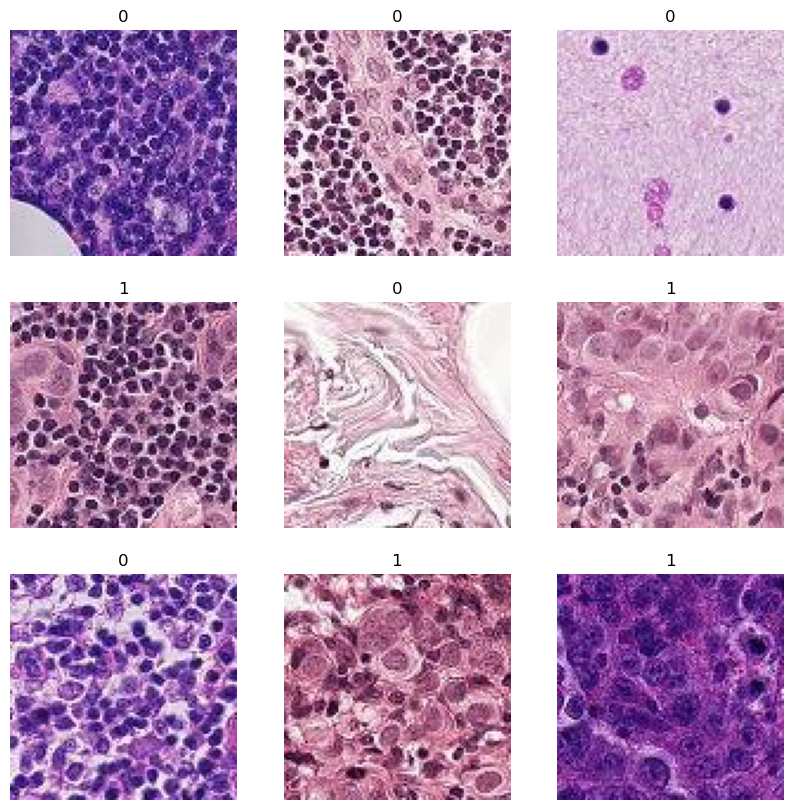

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


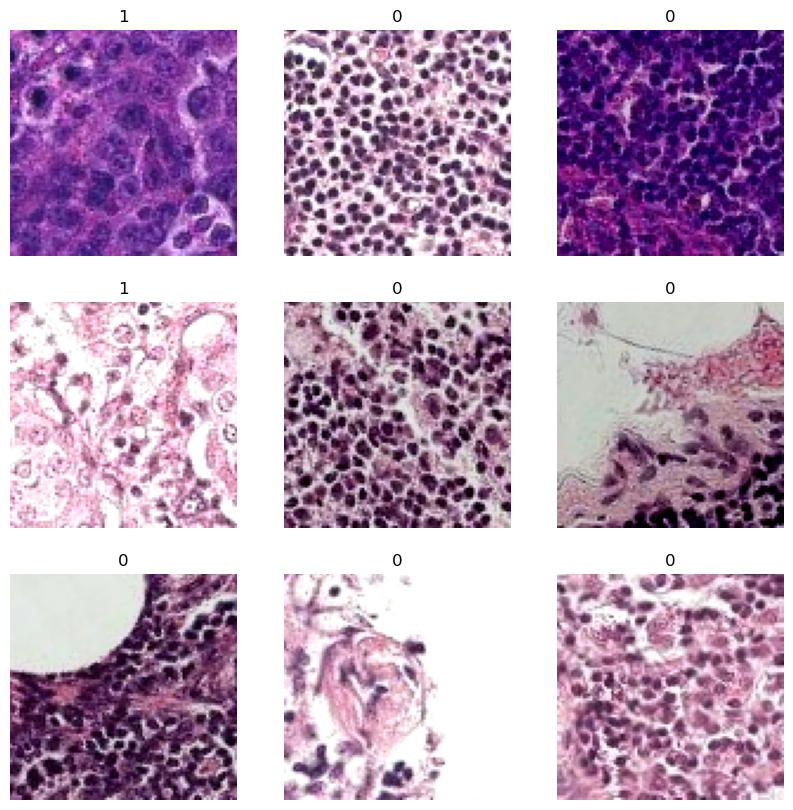

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images[i:i+1])
        plt.imshow(np.array(augmented_image[0]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
# apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [20]:
simple_cnn = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

In [21]:
simple_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
# fit 
history = simple_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10


2025-07-27 07:19:05.222935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5581 - loss: 2047.2601 - val_accuracy: 0.5945 - val_loss: 31.1993
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6127 - loss: 89.5297 - val_accuracy: 0.6820 - val_loss: 18.8480
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5756 - loss: 1968.5129 - val_accuracy: 0.7350 - val_loss: 123.3724
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7023 - loss: 145.5971 - val_accuracy: 0.6635 - val_loss: 141.5885
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6915 - loss: 94.2027 - val_accuracy: 0.5955 - val_loss: 289.9737


In [30]:
# predict on the test dataset
predictions = simple_cnn.predict(test_ds)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities
predictions = predictions.flatten()  # Flatten to 1D array

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [31]:
# precent of predictions by label
percent_0 = np.mean(predictions == 0) * 100
percent_1 = np.mean(predictions == 1) * 100
print(f"Predictions: {percent_0:.2f}% label 0, {percent_1:.2f}% label 1")
print(f"Total predictions: {len(predictions)}, label 0: {np.sum(predictions == 0)}, label 1: {np.sum(predictions == 1)}")

Predictions: 65.09% label 0, 34.91% label 1
Total predictions: 57458, label 0: 37401, label 1: 20057


In [32]:
def build_custom_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = build_custom_cnn(input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL), num_classes=2)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 96, 96, 3) │          0 │ input_layer_4[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │      3,584 │ rescaling_1[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 48, 48,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 48, 48,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ max_pooling2d_1[… │
│                     │ 256)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 24, 24,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      2,048 │ separable_conv2d

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

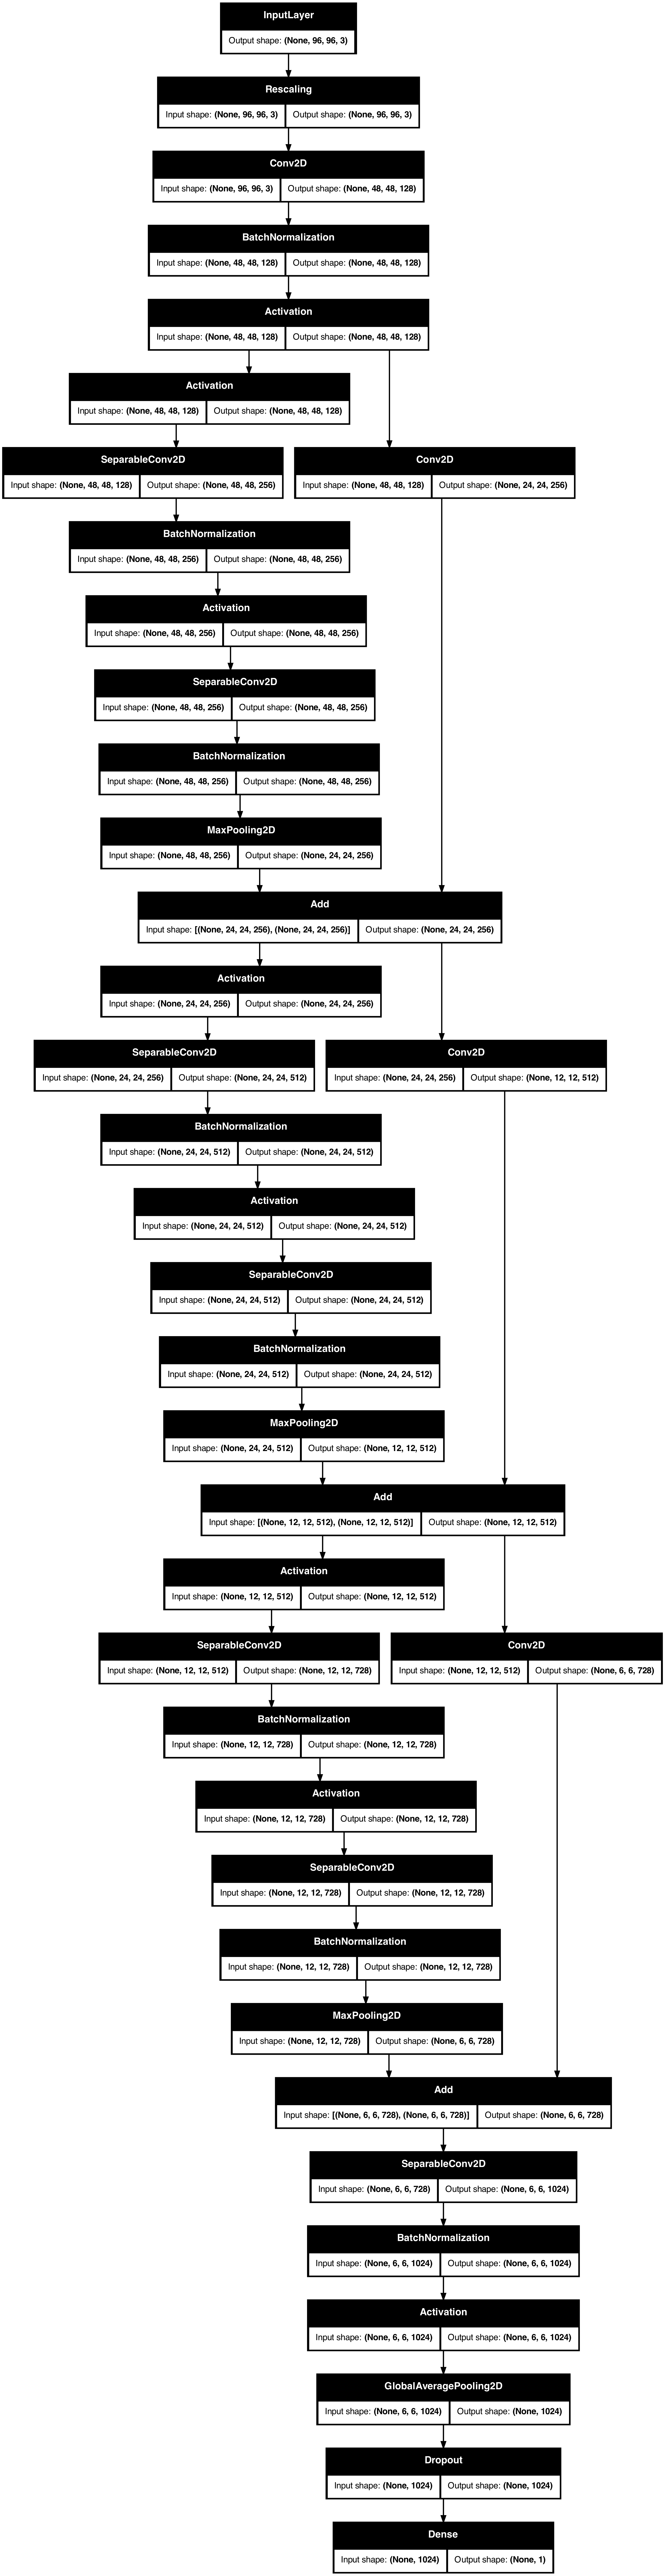

In [33]:
keras.utils.plot_model(model, show_shapes=True)

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.keras"),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Class weights
labels = df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}



# Train custom CNN
history_custom = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - acc: 0.7433 - loss: 0.5439 - val_acc: 0.5835 - val_loss: 0.6820
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 115ms/step - acc: 0.7909 - loss: 0.4743 - val_acc: 0.5835 - val_loss: 0.8677
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - acc: 0.8092 - loss: 0.4379 - val_acc: 0.8000 - val_loss: 0.4511
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - acc: 0.8209 - loss: 0.4143 - val_acc: 0.7920 - val_loss: 0.4263
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - acc: 0.8240 - loss: 0.4082 - val_acc: 0.7160 - val_loss: 0.5277
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - acc: 0.8374 - loss: 0.3882 - val_acc: 0.8120 - val_loss: 0.4674
Epoch 7/25
164/250 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 0.8463 - loss: 0.3715

KeyboardInterrupt: 

In [ ]:
from datetime import datetime

def predict_and_save_submission(model: keras.Model, model_name: str, test_dataset: tf.data.Dataset, output_dir: str):
    # Predict
    test_ids = [f[:-4] for f in os.listdir(test_processed_dir) if f.endswith('.jpg')]
    predictions = model.predict(test_dataset).flatten()
    submission = pd.DataFrame({'id': test_ids, 'label': (predictions > 0.5).astype(int)})

    # Save submission with date and time in the filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    submission_filename = f'submission_{model_name}_{timestamp}.csv'
    print(f"Saving submission to {submission_filename}")
    submission.to_csv(os.path.join(output_dir, submission_filename), index=False)

In [ ]:
predict_and_save_submission(model, "custom_cnn", test_ds, output_dir='./submissions')

In [ ]:
# ResNet50V2
from tensorflow.keras.applications import ResNet50V2

def build_resnet():
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL))
    base_model.trainable = False  # Freeze base initially
    
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

resnet_model = build_resnet()
resnet_model.summary()

In [ ]:
keras.utils.plot_model(resnet_model, show_shapes=True)

In [ ]:
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[
            keras.callbacks.ModelCheckpoint("checkpoints/resnet_save_at_{epoch}.keras"),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

In [ ]:
predict_and_save_submission(resnet_model, "resnet", test_ds, output_dir='./submissions')

In [ ]:
# Fine-tune ResNet: Unfreeze top layers
resnet_model.layers[0].trainable = True
for layer in resnet_model.layers[0].layers[:-10]:  # Fine-tune last 10
    layer.trainable = False
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC()])    

In [ ]:
history_resnet_finetuned = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[
            keras.callbacks.ModelCheckpoint("checkpoints/resnet_finetuned_save_at_{epoch}.keras"),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ])

In [ ]:
predict_and_save_submission(resnet_model, "resnet_finetuned", test_ds, output_dir='./submissions')

In [ ]:
predict_and_save_submission(simple_cnn, "simple_cnn", test_ds, output_dir='./submissions')

In [ ]:
pd.DataFrame(history_custom.history).plot()

In [ ]:
pd.DataFrame(history_resnet.history).plot()

In [ ]:
pd.DataFrame(history_resnet_finetuned.history).plot()